In [21]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers

#### Import data and labels


In [2]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'
  
with open(data_path+'/simulation.npy', 'rb') as f:    #'+str(sim_num)+'
    data_in = np.load(f)
with open(data_path+'/inner_ph.npy', 'rb') as g:      #'+str(sim_num)+'
    inner_ph_in = np.load(g)
### Preprocessing

### Preprocessing

In [3]:
###### parameters #################
root_threshold = 10
###### fixed parameters ###########
n_cam_in_grain = 54
cam_side_length = 31
renormalisation = 10000
###################################

data = (data_in).reshape(-1, n_cam_in_grain, cam_side_length**2)
print('data shape (n_data, n_cam, cam_shape) :',data.shape)

print('\n' + '################ process data from root file ################') 
  
inner_ph = inner_ph_in.reshape(n_cam_in_grain, -1)    #inner_ph_in.reshape(76,-1)  
print('inner photons shape :',inner_ph.shape)
  
overthr_inner_evn = np.unique( np.where( inner_ph > root_threshold )[1] )
label = np.zeros(inner_ph_in.size).reshape(-1, n_cam_in_grain)

for evn in overthr_inner_evn:
    for cam in np.unique( np.where( inner_ph.T[evn] > root_threshold ) ):
        label[evn][cam] = 1
print('labelled blind :', np.where(label==1)[0].size)

data shape (n_data, n_cam, cam_shape) : (1000, 54, 961)

################ process data from root file ################
inner photons shape : (54, 1000)
labelled blind : 742


#### Split into test and training sets

In [4]:
train_data, test_data = data[:800], data[800:]
train_label, test_label = label[:800], label[800:]

train_data.shape

(800, 54, 961)

In [5]:
train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= renormalisation
test_data /= renormalisation

train_label = train_label.flatten()
test_label = test_label.flatten()

train_label_ohe = to_categorical(train_label,2)
test_label_ohe = to_categorical(test_label,2)

test_label_ohe[0]

array([1., 0.], dtype=float32)

## CNN model


Epoch 1/30
1350/1350 [==============================] - 29s 21ms/step - loss: 0.0661 - accuracy: 0.9875 - val_loss: 0.0610 - val_accuracy: 0.9865
Epoch 2/30
1350/1350 [==============================] - 27s 20ms/step - loss: 0.0552 - accuracy: 0.9886 - val_loss: 0.0588 - val_accuracy: 0.9866
Epoch 3/30
1350/1350 [==============================] - 27s 20ms/step - loss: 0.0510 - accuracy: 0.9890 - val_loss: 0.0586 - val_accuracy: 0.9874
Epoch 4/30
1350/1350 [==============================] - 27s 20ms/step - loss: 0.0488 - accuracy: 0.9892 - val_loss: 0.0539 - val_accuracy: 0.9878
Epoch 5/30
1350/1350 [==============================] - 27s 20ms/step - loss: 0.0472 - accuracy: 0.9894 - val_loss: 0.0534 - val_accuracy: 0.9881
Epoch 6/30
1350/1350 [==============================] - 27s 20ms/step - loss: 0.0464 - accuracy: 0.9894 - val_loss: 0.0501 - val_accuracy: 0.9879
Epoch 7/30
1350/1350 [==============================] - 26s 19ms/step - loss: 0.0452 - accuracy: 0.9895 - val_loss: 0.0553 -

<AxesSubplot: >

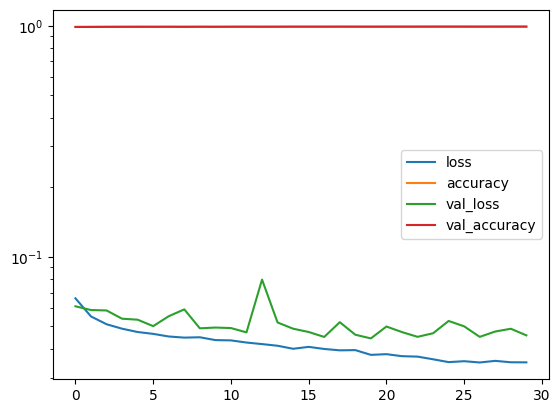

In [28]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(cam_side_length,cam_side_length,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

#train the model
history_callback = model.fit(train_data, train_label_ohe, validation_data=(test_data, test_label_ohe), epochs=30)
pd.DataFrame(history_callback.history).plot(logy=True)


In [29]:
test_loss, test_acc = model.evaluate(test_data, test_label_ohe)
print('test_acc:', test_acc)
#previous was: test_acc: 0.9894444346427917

pred = model.predict(test_data)
pred = np.around(pred) 

pred_dec = np.dot(pred, np.array([0,1], dtype='float32'))
pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print(np.where(pred_dec==1))
print(np.where(pred_lab==1))

write_pdf = True
if write_pdf :
    pdf = PdfPages('./cnn.pdf')
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE negative')
        pdf.savefig(fig)
        plt.close()
    pdf.close()

338/338 [==============================] - 3s 9ms/step - loss: 0.0457 - accuracy: 0.9894
test_acc: 0.9894444346427917
338/338 [==============================] - 3s 7ms/step
labelled : 164
predicted : 60
true positive : 55
false positive : [2827 4303 4761 5605 9620]
false negative : 109


(array([   97,   218,   230,   260,   285,   301,   480,   811,  1075,
        1108,  1122,  1650,  1656,  2403,  2816,  2827,  2829,  2831,
        3286,  3385,  3407,  3520,  3798,  4216,  4303,  4380,  4761,
        4876,  5100,  5164,  5191,  5356,  5605,  5812,  6406,  6689,
        6918,  7121,  7122,  7149,  7270,  7271,  7697,  7708,  8039,
        8149,  8185,  8432,  8979,  9025,  9064,  9400,  9514,  9572,
        9620, 10107, 10210, 10518, 10549, 10618], dtype=int64),)
(array([   64,    73,    97,   218,   230,   260,   274,   285,   301,
         427,   428,   479,   480,   482,   811,   987,  1075,  1108,
        1122,  1444,  1515,  1604,  1607,  1608,  1643,  1644,  1650,
        1656, 

1/1 [==============================] - 0s 48ms/step
[[0.5018886  0.49811143]] [[1. 0.]]
cam n° : 5356


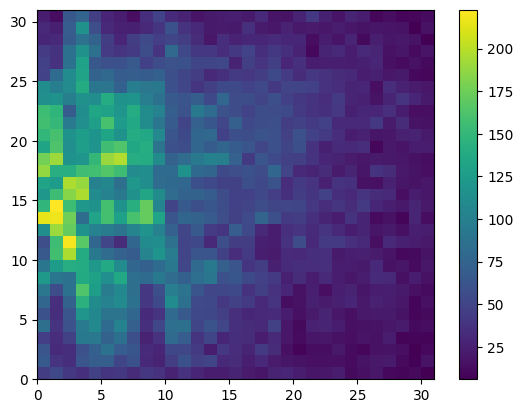

In [8]:
ex = np.where(test_label==1)[0][91]
predex = model.predict(test_data[ex].reshape(-1, cam_side_length, cam_side_length, 1))
print(predex, np.around(predex))
print('cam n° :',ex)

cam = plt.pcolormesh(test_data[4303].reshape(cam_side_length, cam_side_length)*renormalisation)
plt.colorbar(cam)  